<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [82]:
#Start Here
import numpy as np
import pandas as pd
import gensim
import os, sys, re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
# Load dataset
df = pd.read_csv("./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

# 1. Text Cleaning

In [67]:
# tokenize and remove stopwords
tokenized_reviews = [[token for token in simple_preprocess(review) if token not in STOPWORDS] \
                      for review in df['reviews.text']]


In [66]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokenized_reviews[0]]])

['order', 'item', 'bad', 'quality', 'missing', 'backup', 'spring', 'pcs', 'aluminum', 'battery', 'work']


In [68]:
# make functions w/ bigram, trigram, and lemmatization

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [69]:
tokenized_reviews_bigrams = make_bigrams(tokenized_reviews)

tokenized_reviews_lemmatized = lemmatization(tokenized_reviews_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tokenized_reviews_lemmatized[:1])

[['order', 'item', 'bad', 'quality', 'miss', 'backup', 'spring', 'pcs', 'aluminum', 'battery', 'work']]


In [70]:
df['reviews.tokenized'] = pd.Series(tokenized_reviews)

# 2.  Create Dictionary and Corpus for Topic Modeling

In [71]:
def get_reviews(df, token_col):
    """
    Generator function that takes a dataframe with a tokenized column and yields a tokenized 
    row for processing
    
    Parameters:
    -----------
    df: dataframe
    taken_col: name of the column of tokenized text
    
    Yields:
    -------
    review_token: one record of tokenized review
    """
    assert token_col in df.columns, f"{token_col} does not exist!"
    
    for index, row in df.iterrows():
        review_token = row[token_col]
        yield review_token

In [72]:
# construct a dictionary of tokenized words with their respective ids
id2word = corpora.Dictionary(get_reviews(df, 'reviews.tokenized'))

In [73]:
# check the id of word 'brand'
print(f'The id for word "brand" is {id2word.token2id["brand"]}.')
print(f'The size of the id2word dictionary is {sys.getsizeof(id2word)}.')
print(f'There are {len(id2word.keys())} unique words in the dictionary.')

The id for word "brand" is 21.
The size of the id2word dictionary is 56.
There are 9621 unique words in the dictionary.


In [74]:
# First, get the corpus into a bag of words, then build the LDA model for the corpus/words
corpus = [id2word.doc2bow(review) for review in get_reviews(df, 'reviews.tokenized')]

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=45, # random state for multicore doesnt work in gensim
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [75]:
lda.print_topics()

[(0,
  '0.091*"old" + 0.073*"year" + 0.058*"loves" + 0.042*"bought" + 0.023*"use" + 0.022*"tablet" + 0.018*"games" + 0.015*"granddaughter" + 0.015*"grandson" + 0.014*"yr"'),
 (1,
  '0.099*"great" + 0.089*"good" + 0.083*"price" + 0.076*"batteries" + 0.035*"work" + 0.026*"long" + 0.025*"value" + 0.023*"buy" + 0.020*"quality" + 0.018*"brand"'),
 (2,
  '0.081*"battery" + 0.057*"life" + 0.052*"long" + 0.037*"time" + 0.018*"bought" + 0.015*"money" + 0.014*"longer" + 0.013*"lasts" + 0.011*"lasted" + 0.010*"hours"'),
 (3,
  '0.039*"tablet" + 0.035*"books" + 0.029*"great" + 0.022*"amazon" + 0.020*"reading" + 0.019*"read" + 0.019*"use" + 0.018*"easy" + 0.017*"games" + 0.016*"movies"'),
 (4,
  '0.052*"tablet" + 0.032*"good" + 0.023*"great" + 0.022*"amazon" + 0.019*"apps" + 0.016*"kids" + 0.016*"price" + 0.015*"ipad" + 0.011*"google" + 0.011*"time"'),
 (5,
  '0.088*"batteries" + 0.022*"amazon" + 0.013*"work" + 0.013*"duracell" + 0.012*"use" + 0.012*"battery" + 0.010*"long" + 0.010*"ve" + 0.009*"aa

In [78]:
# print the topics in a more readable manner
topics = [' '.join(re.findall(r'"([^"]*)"',t[1])) for t in lda.print_topics()]
print(*topics, sep = "\n\n") 

old year loves bought use tablet games granddaughter grandson yr

great good price batteries work long value buy quality brand

battery life long time bought money longer lasts lasted hours

tablet books great amazon reading read use easy games movies

tablet good great amazon apps kids price ipad google time

batteries amazon work duracell use battery long ve aa brand

great tablet gift bought loves christmas price product got works

kindle screen new like light love read reading reader better

needs laptop charging keyboard screen charger entertained great kids parents

love kids tablet bought games case play kindle great parental

works excellent buy charge better batteries fine time worked fast

easy use tablet great recommend love perfect size kids product

apps kid friendly loves lots kids tablet user ok games

like batteries amazon need use box ve come came store

device tablet nephew amazon good account advertised ads entertainment äôs


In [77]:
# coherence score. higher the better.
print(f'Perplexity: {lda.log_perplexity(corpus)}') 
cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
print(f'Coherence score: {cm.get_coherence()}')

Perplexity: -7.0046730050074135
Coherence score: -3.318288136894442


# 3. Find the optimal number of topics for LDA

In [108]:
def compute_coherence_values(dictionary, corpus, df, token_col, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    tokens = list(get_reviews(df, token_col))
    
    # for iter_ in range(passes):
    for num_topics in range(start, limit, step):
        stream = get_reviews(df, token_col)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
        model_list.append(model)
        # coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')  u_mass giving -2.x coherence scores
        coherencemodel = CoherenceModel(model=model, texts=df[token_col], dictionary=dictionary,corpus=corpus, coherence='c_v')
        coherence_values.append({#'pass': iter_, 
                                 'num_topics': num_topics, 
                                 'coherence_score': coherencemodel.get_coherence()
                                })

    return model_list, coherence_values

In [109]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        df=df, 
                                                        token_col='reviews.tokenized', 
                                                        start=2, 
                                                        limit=14)

In [110]:
len(coherence_values), len(model_list)

(4, 4)

In [111]:
coherence_values[0]

{'num_topics': 2, 'coherence_score': 0.2503734412598003}

In [112]:
cv_list = [d['coherence_score'] for d in coherence_values]

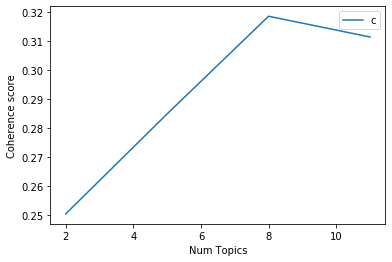

In [113]:
# Show graph
limit=14; start=2; step=3;
x = range(start, limit, step)
plt.plot(x,  cv_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [114]:
# Print the coherence scores
for m, cv in zip(x, cv_list):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2504
Num Topics = 5  has Coherence Value of 0.2848
Num Topics = 8  has Coherence Value of 0.3184
Num Topics = 11  has Coherence Value of 0.3113


In [116]:
best_lda = model_list[2]

In [118]:
#Visualize LDA
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_lda, corpus, id2word)#, sort=False)

c:\users\han-chung lee\.virtualenvs\ds-unit-4-sprint-1-nlp-o1ln3r8m\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.033818 -0.076420       1        1  16.938377
6     -0.049777 -0.034689       2        1  15.474887
1     -0.034809 -0.031164       3        1  15.387604
0      0.027184  0.023546       4        1  14.697598
7     -0.040489  0.103984       5        1  13.508619
2      0.126032 -0.015488       6        1   8.714030
5      0.007291  0.019636       7        1   7.703099
3     -0.001614  0.010596       8        1   7.575782, topic_info=     Category         Freq       Term        Total  loglift  logprob
4196  Default  7610.000000     tablet  7610.000000  30.0000  30.0000
2050  Default  2336.000000       apps  2336.000000  29.0000  29.0000
2616  Default  2772.000000      loves  2772.000000  28.0000  28.0000
22    Default  9249.000000      great  9249.000000  27.0000  27.0000
18    Default  4726.000000      price  4726.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
35     Topic8   173.616150       good  5354.704102  -0.8487  -4.9364
19     Topic8   160.090042  batteries  6457.827148  -1.1171  -5.0175
2245   Topic8   119.442421     screen  1933.851196  -0.2042  -5.3104
13     Topic8   121.088799       like  2585.607178  -0.4810  -5.2967
2050   Topic8   118.973022       apps  2336.275391  -0.3972  -5.3143

[701 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
59        1  0.159864   aaa
59        2  0.140680   aaa
59        3  0.364490   aaa
59        4  0.054354   aaa
59        5  0.067143   aaa
...     ...       ...   ...
1566      4  0.740646   yrs
1566      5  0.021784   yrs
1566      7  0.065351   yrs
2017      1  0.076335  zone
2017      4  0.839684  zone

[2277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 2, 1, 8, 3, 6, 4])

In [119]:
# Overall Model / Documents
print(lda[corpus[0]])
distro = [lda[d] for d in corpus]
print(distro[0])
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

[(1, 0.29845995), (8, 0.6292417)]
[(1, 0.29848537), (8, 0.62921625)]


In [120]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,num_topics,coherence_score
0,2,0.250373
1,5,0.284810
2,8,0.318430
3,11,0.311282


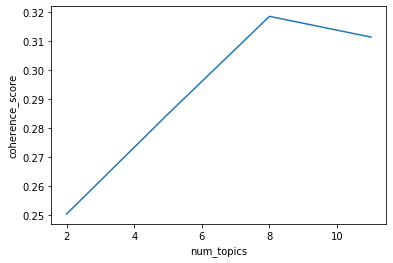

In [121]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# Findings

There seem to be a lot of reviews that's centered around battery/batteries and kindle tablets. Also, some keywords are kindle, tablet, love, and price. Combined with the 15 topics that LDA chose, it seems Amazon's tablet is a hit from the first impression. And as with normal consumer behavior, people care about price and value and tend to buy things as gift, especially during Christmas.

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling